In [35]:
#Find Tickers

In [36]:
import numpy as np
import pandas as pd
import yfinance as yf
import datetime
import matplotlib.pyplot as plt
import seaborn
from statsmodels.tsa.stattools import coint

In [37]:
filename='data/finance.csv'
df = pd.read_csv(filename, index_col = 0)
df.head()

,Symbol,Name,Price (Intraday),Change,% Change,Volume,Avg Vol (3 month),Market Cap,PE Ratio (TTM),52 Week Range
0,BRK-B,Berkshire Hathaway Inc.,345.45,-0.89,-0.26%,2.754M,3.074M,753.385B,8.68,NaN
1,BRK-A,Berkshire Hathaway Inc.,523690.12,-1734.88,-0.33%,9421,7779,752.831B,8.77,NaN
2,V,Visa Inc.,234.44,-0.60,-0.26%,5.372M,5.229M,487.588B,29.79,NaN
3,JPM,JPMorgan Chase & Co.,144.77,-0.33,-0.23%,6.943M,9.104M,420.715B,9.31,NaN
4,MA,Mastercard Incorporated,394.74,-3.23,-0.81%,2.474M,2.291M,371.929B,37.00,NaN


In [38]:
df.shape

(100, 10)

In [39]:
def convert_volume(value):
    if 'M' in value:
        return float(value.replace('M', '')) * 1e6  # Convert to millions
    elif 'k' in value:
        return float(value.replace('k', '')) * 1e3  # Convert to thousands
    else:
        return float(value)  # No conversion needed

# Apply the conversion function to the 'Volume' column
df['Avg Vol (3 month)'] = df['Avg Vol (3 month)'].apply(convert_volume)

In [40]:
# Define a volume cap
volume_cap = 1000000

df['Avg Vol (3 month)'] = pd.to_numeric(df['Avg Vol (3 month)'], errors='coerce')
df['Price (Intraday)'] = pd.to_numeric(df['Price (Intraday)'], errors='coerce')

df = df[['Symbol','Avg Vol (3 month)','Price (Intraday)']].sort_values(by='Avg Vol (3 month)', ascending=False)

high_volume = df["Avg Vol (3 month)"]>volume_cap
df_h = df[high_volume]
tickers = df_h.Symbol.tolist()
tickers

['BAC',
 'ITUB',
 'C',
 'WFC',
 'PYPL',
 'USB',
 'SCHW',
 'JPM',
 'MS',
 'BX',
 'V',
 'IBN',
 'MET',
 'KKR',
 'SAN',
 'BRK-B',
 'UBS',
 'MUFG',
 'AXP',
 'PGR',
 'ICE',
 'TD',
 'BN',
 'ING',
 'MA',
 'APO',
 'PNC',
 'HDB',
 'GS',
 'HSBC',
 'CB',
 'SMFG',
 'BNS',
 'MMC',
 'CME',
 'SPGI',
 'BBVA',
 'RY']

In [41]:
#period = '1y' #valid periods: 1d,5d,1mo,3mo,6mo,1y,2y,5y,10y,ytd,max
#interval = '1d' #valid intervals: 1m,2m,5m,15m,30m,60m,90m,1h,1d,5d,1wk,1mo,3mo
#df = yf.download(tickers, period=period, interval=interval)["Close"]


# Enable to use start & end dates:
start = datetime.date.today() - datetime.timedelta(days=430)
end = datetime.date.today() - datetime.timedelta(days=60)

df = yf.download(tickers, start, end)["Close"]

df.info()

[*********************100%%**********************]  38 of 38 completed
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 254 entries, 2022-08-05 to 2023-08-09
Data columns (total 38 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   APO     254 non-null    float64
 1   AXP     254 non-null    float64
 2   BAC     254 non-null    float64
 3   BBVA    254 non-null    float64
 4   BN      254 non-null    float64
 5   BNS     254 non-null    float64
 6   BRK-B   254 non-null    float64
 7   BX      254 non-null    float64
 8   C       254 non-null    float64
 9   CB      254 non-null    float64
 10  CME     254 non-null    float64
 11  GS      254 non-null    float64
 12  HDB     254 non-null    float64
 13  HSBC    254 non-null    float64
 14  IBN     254 non-null    float64
 15  ICE     254 non-null    float64
 16  ING     254 non-null    float64
 17  ITUB    254 non-null    float64
 18  JPM     254 non-null    float64
 19  KKR     254 non-null   

In [42]:
df.head()

,APO,AXP,BAC,BBVA,BN,BNS,BRK-B,BX,C,CB,...,RY,SAN,SCHW,SMFG,SPGI,TD,UBS,USB,V,WFC
Date,,,,,,,,,,,,,,,,,,,,,
2022-08-05,57.529999,157.509995,33.959999,4.71,40.299110,60.669998,292.070007,101.199997,51.660000,185.320007,...,97.769997,2.52,69.309998,6.10,376.649994,64.480003,16.219999,47.389999,215.869995,43.759998
2022-08-08,57.419998,157.279999,33.490002,4.72,40.614391,60.900002,292.339996,102.709999,51.470001,186.559998,...,96.900002,2.54,68.449997,6.11,378.119995,64.769997,16.510000,46.950001,213.320007,43.189999
2022-08-09,57.900002,158.800003,33.919998,4.77,40.582054,60.340000,292.769989,100.820000,52.090000,189.710007,...,96.360001,2.58,69.040001,6.05,377.089996,64.250000,16.309999,47.180000,210.259995,43.400002
2022-08-10,59.990002,162.440002,35.070000,4.84,42.821342,62.130001,295.109985,107.940002,53.189999,191.600006,...,98.449997,2.66,69.940002,6.22,393.200012,66.300003,16.780001,47.869999,212.100006,44.330002
2022-08-11,60.889999,162.990005,35.910000,4.85,43.298302,62.400002,296.470001,106.010002,54.000000,193.809998,...,99.339996,2.68,72.570000,6.25,386.170013,66.800003,16.950001,48.439999,211.080002,45.250000


In [43]:
df = df.dropna(axis=0, how='all') # check if necessary
df = df.dropna(axis=1) # check if necessary
new_tickers = df.columns.tolist()
print(f"we have {len(new_tickers)} tickers left")
file_name = "finance_close_prices.pkl"
df.to_pickle(file_name)
df.info()

we have 38 tickers left
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 254 entries, 2022-08-05 to 2023-08-09
Data columns (total 38 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   APO     254 non-null    float64
 1   AXP     254 non-null    float64
 2   BAC     254 non-null    float64
 3   BBVA    254 non-null    float64
 4   BN      254 non-null    float64
 5   BNS     254 non-null    float64
 6   BRK-B   254 non-null    float64
 7   BX      254 non-null    float64
 8   C       254 non-null    float64
 9   CB      254 non-null    float64
 10  CME     254 non-null    float64
 11  GS      254 non-null    float64
 12  HDB     254 non-null    float64
 13  HSBC    254 non-null    float64
 14  IBN     254 non-null    float64
 15  ICE     254 non-null    float64
 16  ING     254 non-null    float64
 17  ITUB    254 non-null    float64
 18  JPM     254 non-null    float64
 19  KKR     254 non-null    float64
 20  MA      254 non-null    float64
 

In [44]:
# let's define a function to loop through the tickers and do a cointegration test for each combination
def cointegration_test(data, p_value=0.05):
    n = data.shape[1]
    # create matrix to be filled later
    stats = np.zeros((n, n))
    pvalues = np.ones((n, n))
    keys = data.keys() # get the info axis, returns columns if object is a dataframe
    pairs = []
    for i in range(n):
        for j in range(i+1, n):
            result = coint(data[keys[i]], data[keys[j]])
            test_stat = result[0]
            pvalue = result[1]
            stats[i, j] = test_stat
            pvalues[i, j] = pvalue

            if pvalue < p_value: # pick only statistically significant ones
                pairs.append((keys[i], keys[j]))

    return stats, pvalues, pairs


[('APO', 'JPM'), ('BBVA', 'SMFG'), ('BBVA', 'V'), ('BNS', 'RY'), ('BX', 'ITUB'), ('C', 'MS'), ('HDB', 'ICE'), ('HDB', 'ING'), ('HDB', 'JPM'), ('HDB', 'MA'), ('HDB', 'PYPL'), ('HDB', 'SMFG'), ('HDB', 'UBS'), ('HDB', 'V'), ('ICE', 'MMC'), ('JPM', 'MA'), ('MS', 'RY'), ('PGR', 'UBS'), ('PYPL', 'V'), ('SAN', 'V'), ('SMFG', 'UBS'), ('TD', 'USB'), ('UBS', 'V')]


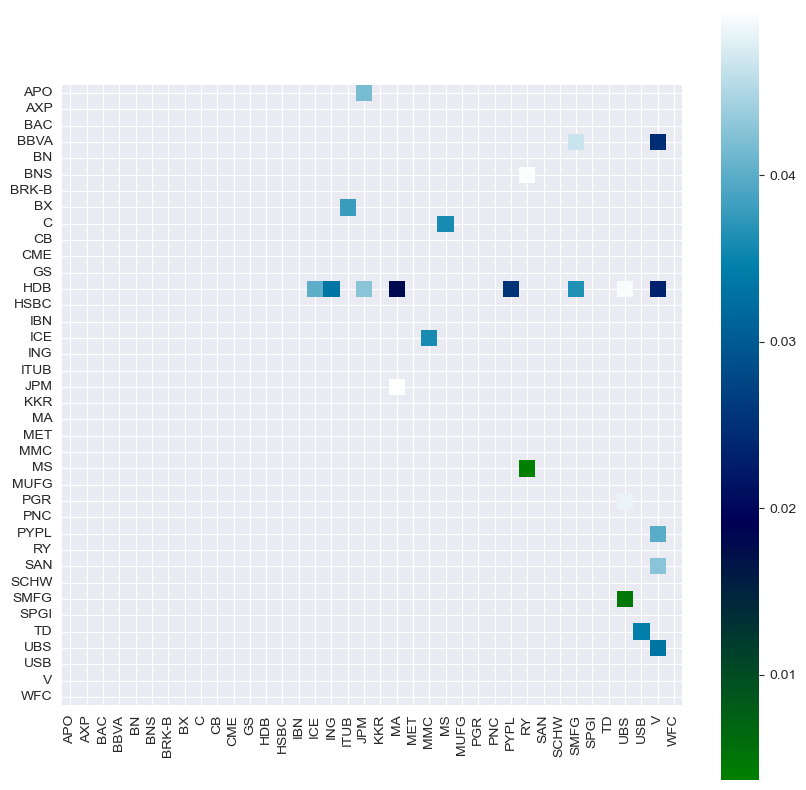

In [45]:
p_value = 0.05  # A p-value less than 0.05 is typically considered to be statistically significant

scores, pvalues, pairs = cointegration_test(df,p_value)

fig, ax = plt.subplots(figsize=(10, 10))
seaborn.heatmap(
    pvalues,
    xticklabels=new_tickers,
    yticklabels=new_tickers,
    cmap="ocean",
    mask=(pvalues >= 0.05),
    square=True
)
print(pairs)

,ICE,ING,ITUB,JPM,MA,MMC,MS,PYPL,RY,SMFG,UBS,USB,V
APO,nan,nan,nan,0.042,nan,nan,nan,nan,nan,nan,nan,nan,nan
BBVA,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.047,nan,nan,0.024
BNS,nan,nan,nan,nan,nan,nan,nan,nan,0.050,nan,nan,nan,nan
BX,nan,nan,0.038,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
C,nan,nan,nan,nan,nan,nan,0.036,nan,nan,nan,nan,nan,nan
HDB,0.040,0.033,nan,0.043,0.018,nan,nan,0.025,nan,0.036,0.049,nan,0.023
ICE,nan,nan,nan,nan,nan,0.036,nan,nan,nan,nan,nan,nan,nan
JPM,nan,nan,nan,nan,0.050,nan,nan,nan,nan,nan,nan,nan,nan
MS,nan,nan,nan,nan,nan,nan,nan,nan,0.004,nan,nan,nan,nan
PGR,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.048,nan,nan


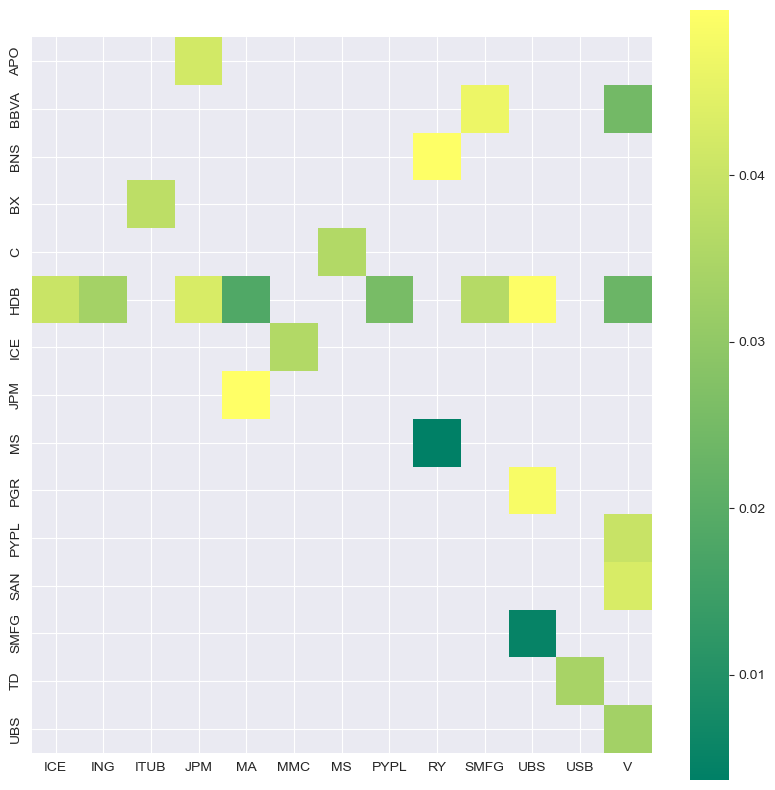

In [46]:
mask_matrix = (pvalues >= 0.05) # possible to increase the level of significance

mask_df = pd.DataFrame(mask_matrix, index= new_tickers, columns = new_tickers)
scores_df = pd.DataFrame(scores, index= new_tickers, columns = new_tickers)
pvalues_df = pd.DataFrame(pvalues, index= new_tickers, columns = new_tickers)

df_f = pvalues_df[~mask_df].dropna(how='all', axis=1)
df_f = df_f.dropna(how='all')

def gold_apply(x):
    color = {True: "background-color: #c78f2e", False: "color : white"}
    is_color = (x > 0).replace(color)
    return is_color


fig, ax = plt.subplots(figsize=(10, 10))
seaborn.heatmap(
    df_f,
    xticklabels=df_f.columns,
    yticklabels=df_f.index,
    cmap="summer",
    square=True
)
df_f.style.format(precision=3) \
    .apply(gold_apply)

In [47]:
x_list = df_f.index.tolist()
y_list = df_f.columns.tolist()

new_pairs_list = [] # list of pairs as tuples (A,B)

for i in range(len(x_list)):
    for j in range(len(y_list)):
        if df_f.iloc[i,j]>0:
            new_pairs_list.append((x_list[i], y_list[j]))

new_pairs_list

[('APO', 'JPM'),
 ('BBVA', 'SMFG'),
 ('BBVA', 'V'),
 ('BNS', 'RY'),
 ('BX', 'ITUB'),
 ('C', 'MS'),
 ('HDB', 'ICE'),
 ('HDB', 'ING'),
 ('HDB', 'JPM'),
 ('HDB', 'MA'),
 ('HDB', 'PYPL'),
 ('HDB', 'SMFG'),
 ('HDB', 'UBS'),
 ('HDB', 'V'),
 ('ICE', 'MMC'),
 ('JPM', 'MA'),
 ('MS', 'RY'),
 ('PGR', 'UBS'),
 ('PYPL', 'V'),
 ('SAN', 'V'),
 ('SMFG', 'UBS'),
 ('TD', 'USB'),
 ('UBS', 'V')]

In [48]:
new_pairs_str =[] # list of pairs as string A-B

for column in df_f:
    toprint = df_f.index[df_f[column]>0].tolist()
    new_pairs_str.append([column + "-" + s for s in toprint])

new_pairs_str

[['ICE-HDB'],
 ['ING-HDB'],
 ['ITUB-BX'],
 ['JPM-APO', 'JPM-HDB'],
 ['MA-HDB', 'MA-JPM'],
 ['MMC-ICE'],
 ['MS-C'],
 ['PYPL-HDB'],
 ['RY-BNS', 'RY-MS'],
 ['SMFG-BBVA', 'SMFG-HDB'],
 ['UBS-HDB', 'UBS-PGR', 'UBS-SMFG'],
 ['USB-TD'],
 ['V-BBVA', 'V-HDB', 'V-PYPL', 'V-SAN', 'V-UBS']]

In [49]:
new_pairs_dic= {} # list of pairs as dictionary {'A':['B','C']}

for column in df_f:
    new_pairs_dic[column] = df_f.index[df_f[column]>0].tolist()

new_pairs_dic

{'ICE': ['HDB'],
 'ING': ['HDB'],
 'ITUB': ['BX'],
 'JPM': ['APO', 'HDB'],
 'MA': ['HDB', 'JPM'],
 'MMC': ['ICE'],
 'MS': ['C'],
 'PYPL': ['HDB'],
 'RY': ['BNS', 'MS'],
 'SMFG': ['BBVA', 'HDB'],
 'UBS': ['HDB', 'PGR', 'SMFG'],
 'USB': ['TD'],
 'V': ['BBVA', 'HDB', 'PYPL', 'SAN', 'UBS']}

In [50]:
df_f.to_pickle("pairs_to_download.pkl")

In [51]:
new_pairs_dic

{'ICE': ['HDB'],
 'ING': ['HDB'],
 'ITUB': ['BX'],
 'JPM': ['APO', 'HDB'],
 'MA': ['HDB', 'JPM'],
 'MMC': ['ICE'],
 'MS': ['C'],
 'PYPL': ['HDB'],
 'RY': ['BNS', 'MS'],
 'SMFG': ['BBVA', 'HDB'],
 'UBS': ['HDB', 'PGR', 'SMFG'],
 'USB': ['TD'],
 'V': ['BBVA', 'HDB', 'PYPL', 'SAN', 'UBS']}

In [52]:
# Define the file path
file_path = "data/pairs_names.json"

# Save the dictionary to the JSON file
with open(file_path, "w") as json_file:
    json.dump(new_pairs_dic, json_file)


NameError: name 'json' is not defined